In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
run_name = "10_11_19_run_02"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [7]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [8]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [9]:
from pore_utils import raw_signal_utils
from pore_utils import smith_waterman as s_w

ModuleNotFoundError: No module named 'pore_utils'

In [ ]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [ ]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [ ]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

In [ ]:
sw_dir

In [ ]:
sw_list = []
for fname in os.listdir(sw_dir):
    if len(re.findall(r"fastq_runid_.*_[\d]+_[\d]+.tsv", fname)) == 0:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [ ]:
sw_arr = np.array(sw)

In [ ]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

In [ ]:
sw_tsv

## Plot alignment scores for basic overview of performance

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

In [ ]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [ ]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [ ]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [ ]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [ ]:
merged_sw_file

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [ ]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.replace(" ", "").split(",")

In [ ]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)
molbits_on_flowcell = list(np.unique(molbits_on_flowcell))

## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [ ]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

In [ ]:
len(accept_molbit)

In [ ]:
sum(accept_molbit)

In [ ]:
sum(accept_molbit) / len(accept_molbit)

## Extract the best-aligned molbit, across ONLY the extant molbits

In [ ]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [ ]:
extant_sw = sw.loc[:, extant_sw_cols]

In [ ]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

## Compare 

In [ ]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [ ]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [ ]:
n_extant_is_best

Percentage of well-aligned reads that belong to the true set

In [ ]:
n_extant_is_best/len(sw_accepted)

Read counts for each molbit

In [ ]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

In [ ]:
print("\n".join([str(x) for x in c]))

## Extract the best-aligned molbit, across ONLY the current run's molbits

In [ ]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [ ]:
extant_sw = sw.loc[:, extant_sw_cols]

In [ ]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

## Compare 

In [ ]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [ ]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [ ]:
n_extant_is_best

Percentage of well-aligned reads that belong to the true set

In [ ]:
n_extant_is_best/len(sw_accepted)

Read counts for each molbit

In [ ]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

In [ ]:
l = []
for i in range(0, 96, 16):
    l.extend(range(i, i+8))

In [ ]:
", ".join([str(x) for x in l])

## Get counts for all molbits

In [ ]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

# Plot read counts

In [ ]:
def plot_read_counts(labels, counts, labels_on_flowcell, labels_in_run,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per molbit"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Molbit ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue

#         try:
#             label = int(label)
#         except:
#             pass
        
        if label in labels_in_run:
            g.containers[0].get_children()[j].set_facecolor("tab:red")
            font_kwargs = {"color": "tab:red", "weight": "bold"} 
        elif label in labels_on_flowcell:
            g.containers[0].get_children()[j].set_facecolor("tab:blue")
            font_kwargs = {"color": "k", "weight": "bold"}
        else:
            g.containers[0].get_children()[j].set_facecolor("k")
            font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        prev_text_height = text_height
        
    legend_elements = [Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='median/typical molbits'),
                       Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='highest/lowest molbits')]
    leg = ax.legend(handles=legend_elements)
    t1, t2 = leg.get_texts()
    t2._fontproperties = t1._fontproperties.copy()
#     t3._fontproperties = t1._fontproperties.copy()
    t1.set_weight('bold')
    t2.set_weight('bold')
    t2.set_color("tab:red")
    return ax

# Save labels

In [ ]:
merged_sw_file

In [ ]:
sw = pd.read_csv(merged_sw_file, sep="\t", index_col=0)
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit
sw["best_molbit_is_in_run"] = sw["best_molbit"].apply(lambda x: x in molbits_in_run)

labels_in_set = sw[np.logical_and(sw["accept_molbit"], sw["best_molbit_is_in_run"])]

In [ ]:
sw_label_file = merged_sw_file.replace("all", "labels_for_molbits_in_set")
print(sw_label_file)

In [ ]:
best_score = np.max(labels_in_set[[f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]], axis=1)
labels_in_set["best_score"] = best_score
labels_in_set = labels_in_set.loc[:, ["best_molbit", "best_score"]]
labels_in_set.columns = ["molbit", "sw_score"]

labels_in_set.to_csv(sw_label_file, sep="\t", index=True)

# Attempt to scale the counts

In [ ]:
scaling_factor = [ 117.44079692,  296.08219178,   79.3902663 ,   63.8680128 ,
        301.24041812,  106.23305345,   50.35782934,   94.36710933,
        261.39458779,   23.42805573,  236.19903327,  215.71332122,
         72.68457433, 1674.82258065,  359.61558442,   92.43485034,
         55.15762106,  147.49710313,  161.68942521,   41.8235584 ,
         72.38555587,  124.39775226,  207.99019608,  599.71731449,
        410.15625   ,  146.23955432,   81.21546961,  151.60891089,
        265.91895803,   93.01442673,   59.58171206,   41.92334018,
         75.73638033,  100.18461538,  178.88385542,  176.9227836 ,
         35.15      ,   99.06164932,  435.15123095,  124.01737387,
        100.70515917,  113.01108647,  127.24327323,   34.53376496,
        113.68327138,   86.11075652,  317.00898411,  239.53629243,
         83.78780013,  276.0384821 ,   89.75808133,   32.18069662,
        250.71262136,  310.93798916,   76.84392204,  187.19391084,
        211.31315136,  165.0372093 ,   71.34651475,  403.21590909,
         35.59571978,  201.41721854,  126.01242971,   66.43719769,
       1425.49333333,  102.0477251 ,   39.45092251,   84.89571202,
         68.85702018,  148.00922935,  204.68155712,  104.81568627,
         66.45394046,  150.09968354,   32.68883529,   74.21318208,
        797.16806723,   93.0257416 ,  348.76102941,  372.37684004,
         95.12844828,   56.96902426,  143.82404692,  231.58237146,
        171.5491644 ,   65.69370442,   68.64634526,  119.36073553,
        128.91764706,   32.27093687,  114.79353994,  433.62242374,
         92.13242249,  293.19063545,  129.10751105,   86.49629995]

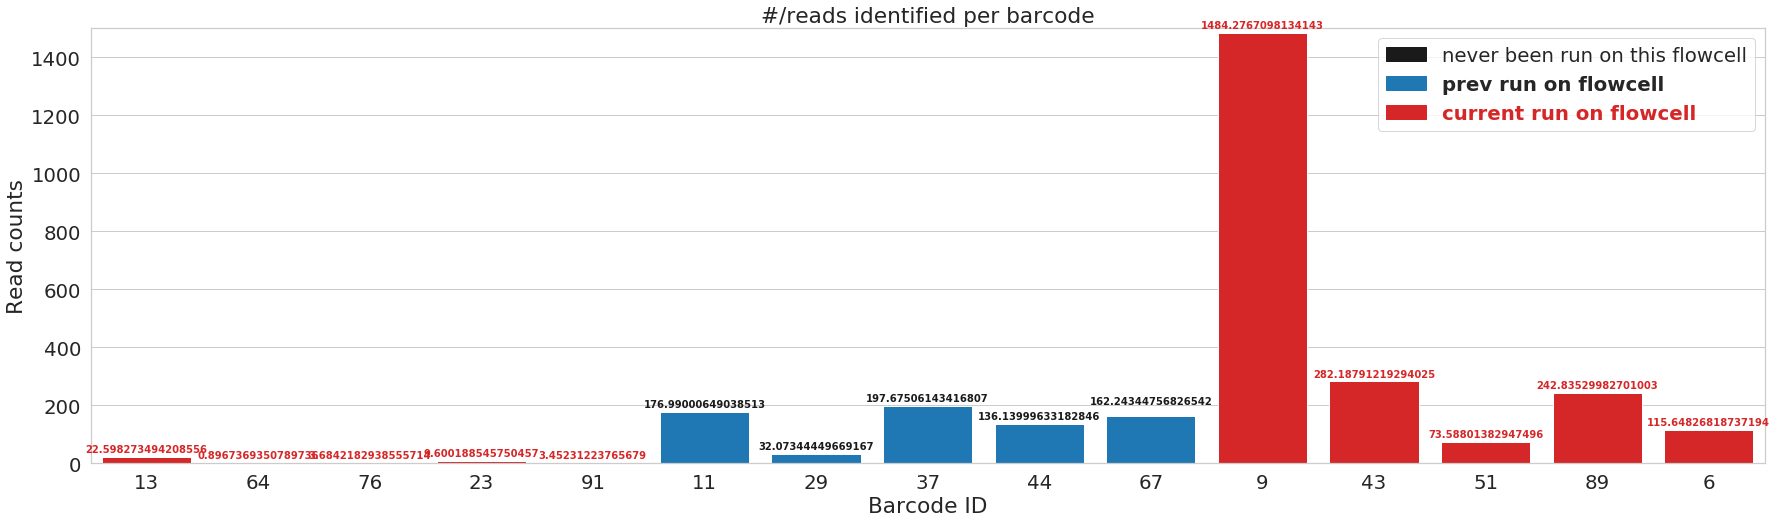

In [119]:
molbits = [str(x) for x in m]
counts = list(c / np.array(scaling_factors_chosen))
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run if str(x) not in medium]
poss_molbits = [str(x) for x in range(96)]
plot_read_counts(molbits, counts, on_flowcell, in_run, possible_labels=low+medium+high, vmax=1500)

# Compare to other data

In [144]:
test_run_names = ["08_28_2019_run_01",
                  "08_30_2019_run_01",]

In [145]:
test_runs = run_spreadsheet[run_spreadsheet["run_name"].apply(lambda x: x in test_run_names)]

In [146]:
test_sw = []
for i, run_data in test_runs.iterrows():
    run_name = run_data["run_name"]
    label_file = run_data["filtered_sw_labels"]
    
    sw = pd.read_csv(label_file, sep="\t", index_col=0)
    sw["run_name"] = run_name
    test_sw.append(sw)
test_sw = pd.concat(test_sw) 

In [147]:
test_molbit_counts = []
test_norms = []
norm_test_molbit_counts = []
test_bits = []
for set_i, start_molbit in enumerate(range(0, 96, 16)):
    for half in [0, 1]:
        if half == 0:
            run_name = test_run_names[0]
            molbits_in_range = range(start_molbit, start_molbit+8)
        else:
            run_name = test_run_names[1]
            molbits_in_range = range(start_molbit+8, start_molbit+16)
        test_sw_run = test_sw[test_sw["run_name"] == run_name]
        filtered_labels_in_run = test_sw_run[test_sw_run["molbit"].apply(lambda x: x in molbits_in_range)]
        l, c = np.unique(filtered_labels_in_run["molbit"], return_counts=True)
        for l_, c_ in zip(l, c):
            test_molbit_counts.append(c_)
            norm_test_molbit_counts.append(c_ / sum(c))
        test_norms.append(sum(c))
        test_bits.append(molbits_in_range)
    

In [160]:
selected_molbits = [int(x) for x in low + medium + high]

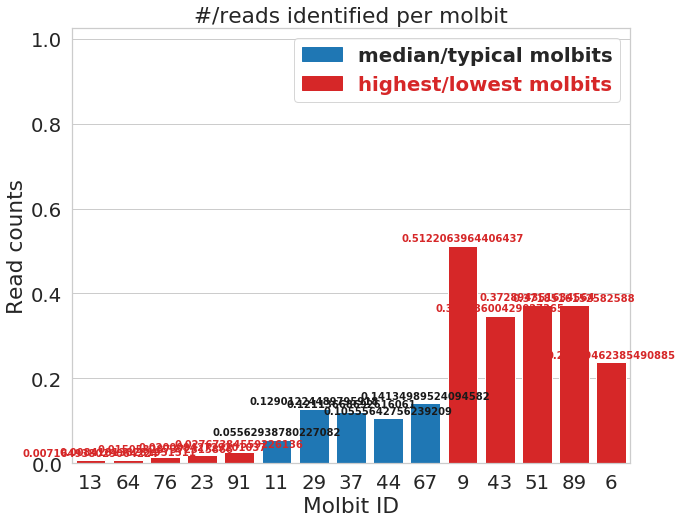

In [159]:
molbits = [str(x) for x in range(96)]
counts = list(c)
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run if str(x) not in medium]
poss_molbits = [str(x) for x in range(96)]
ax = plot_read_counts(molbits, norm_test_molbit_counts, on_flowcell, in_run, possible_labels=low+medium+high)#, vmax=36600, title_note="test data 8/28 and 8/30")

plt.savefig("../v4/plots/read_count_analysis/read_counts_reordered_seqs_in_test_data.svg")

In [183]:
only_selected_molbits_test = np.array(norm_test_molbit_counts)[selected_molbits]
only_selected_molbits_test = only_selected_molbits_test / sum(only_selected_molbits_test)

In [184]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbits = [str(x) for x in m]
order = []
for i in selected_molbits:
    order.append(list(m).index(str(i)))
only_selected_molbits_reorder = c[order]
only_selected_molbits_reorder = only_selected_molbits_reorder / sum(only_selected_molbits_reorder)

In [186]:
list(zip(only_selected_molbits_reorder, only_selected_molbits_test))

[(0.005025347535018459, 0.0028964021824700857),
 (0.000499001996007984, 0.003403004184163723),
 (0.0024420186176319927, 0.00608524096393608),
 (0.006252980764135446, 0.008088743914247725),
 (0.006610672460388957, 0.011187059322163398),
 (0.04991786338826771, 0.02248799355784738),
 (0.08494073799304047, 0.05215276757063835),
 (0.0874534117605497, 0.04896909965820754),
 (0.06054263155105718, 0.04267083203305644),
 (0.04759949128292088, 0.057140221367869094),
 (0.21151943899811, 0.2070577189234361),
 (0.12344337872926713, 0.1404700525142723),
 (0.07783989543037818, 0.1507412917632979),
 (0.12799621994948157, 0.15031976907826977),
 (0.10791690954374437, 0.09632980296612409)]

In [192]:
rows = []
for molbit, reorder_count, test_count in zip(selected_molbits, only_selected_molbits_reorder, only_selected_molbits_test):
    rows.append([molbit, reorder_count, "reorder"])
    rows.append([molbit, test_count, "test"])
data = pd.DataFrame(rows, columns=["molbit", "count", "dataset"])

In [204]:
from matplotlib.patches import Patch

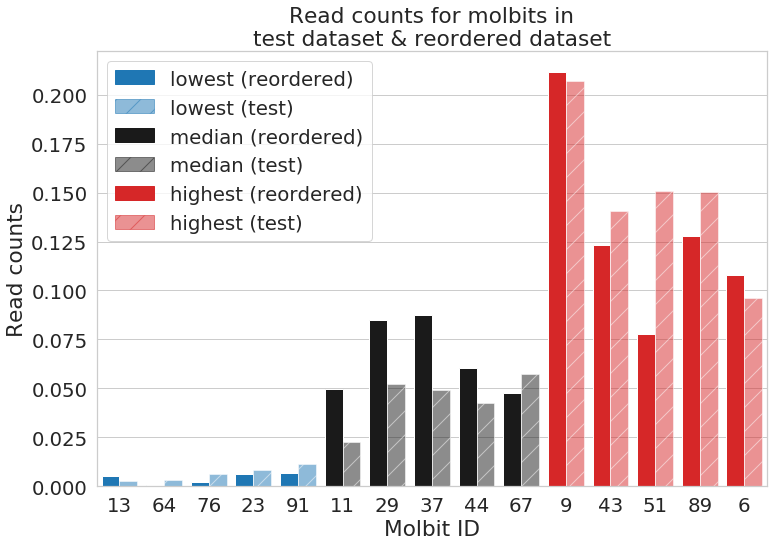

In [209]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(data=data, x="molbit", y="count", hue="dataset", ax=ax, order=selected_molbits)
ax.set_xlabel("Molbit ID")
ax.set_ylabel("Read counts")

for j, label in enumerate(selected_molbits):
    if str(label) in low:
        ax.containers[0].get_children()[j].set_facecolor("tab:blue")
        font_kwargs = {"color": "tab:red", "weight": "bold"}
        ax.containers[1].get_children()[j].set_facecolor("tab:blue")
        ax.containers[1].get_children()[j].set_hatch('/')
        ax.containers[1].get_children()[j].set_alpha(0.5)
        
    elif str(label) in high:
        ax.containers[0].get_children()[j].set_facecolor("tab:red")
        font_kwargs = {"color": "tab:red", "weight": "bold"}
        ax.containers[1].get_children()[j].set_facecolor("tab:red")
        ax.containers[1].get_children()[j].set_hatch('/')
        ax.containers[1].get_children()[j].set_alpha(0.5)
    else:
        ax.containers[0].get_children()[j].set_facecolor("k")
        font_kwargs = {"color": "k", "weight": "normal"}
        ax.containers[1].get_children()[j].set_facecolor("k")
        ax.containers[1].get_children()[j].set_hatch('/')
        ax.containers[1].get_children()[j].set_alpha(0.5)
        
legend_elements = [Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='lowest (reordered)'),
                   Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='lowest (test)', alpha=0.5, hatch="/"),
                   Patch(facecolor='k', edgecolor='k',
                         label='median (reordered)'),
                   Patch(facecolor='k', edgecolor='k',
                         label='median (test)', alpha=0.5, hatch="/"),
                   Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='highest (reordered)'),
                   Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='highest (test)', alpha=0.5, hatch="/"),]
leg = ax.legend(handles=legend_elements)

ax.set_title("Read counts for molbits in\ntest dataset & reordered dataset")
plt.savefig("../v4/plots/read_count_analysis/read_counts_comparison.svg")
plt.savefig("../v4/plots/read_count_analysis/read_counts_comparison.png", dpi=300)